
## <p style="text-align: center;"> SARIMAX Time Series Model to Forecast US Home Sales

### SARIMAX = Seasonal Auto-Regressive Integrated Moving Average with eXogenous variables
<br>
Seasonal - patterns in the data that are tied to specific times of the year<br>
<br>
Auto-Regressive - assumes past values have an effect on future values<br>
<br>
Integrated - use of differencing between current values and past values to ensure a necessary feature of time series models: stationarity<br>
<br>
Moving Average - the lag of residuals; the part of the model that is not explained by trend or seasonality<br>
<br>
Exogenous variables - outside variables for the model to consider (i.e. mortgage rates, housing inventory, etc.)<br>
<br>

In [4]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## Import the necessary packages. If you are missing any packages, then run prerequisite.py file in the repo

In [43]:
import pandas as pd
from openpyxl import workbook
from fredapi import Fred
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import statsmodels.api as sm
import numpy as np
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from numpy import array

## You'll need to generate a key from FRED api for this step. Once you have a key, create a text file and put the path inside of the quotes. Use key to access FRED api.

In [6]:

with open(r"PATH_TO_KEY_HERE") as f:
   key = f.read()

fred = Fred(key)


## Pull in all of the various metrics that might be useful to predicting home sales, as well as the historical sales file. Use the codes inside the quotes of the get_series method to find out more about each metric from FRED (https://fred.stlouisfed.org/)


In [7]:
HomeSales = pd.read_excel(r'Historical_Home_Sales.xlsx').set_index(['Date'])
Exist = pd.DataFrame(fred.get_series('EXHOSLUSM495N')).rename(columns={0:'ExistingHS'})
NewHS = pd.DataFrame(fred.get_series('HSN1FNSA')).rename(columns={0:'NewHS'})
Rates = pd.DataFrame(fred.get_series('MORTGAGE30US')).rename(columns={0:'Rates'})
PenList = pd.DataFrame(fred.get_series('PENLISCOUUS')).rename(columns={0:'PendingLists'})
ActList = pd.DataFrame(fred.get_series('ACTLISCOUUS')).rename(columns={0:'ActiveLists'})
CaseSchuller = pd.DataFrame(fred.get_series('CSUSHPISA')).rename(columns={0:'CS_Index'})
NewComp = pd.DataFrame(fred.get_series('COMPUTNSA')).rename(columns={0:'NewComps'})
NewConst = pd.DataFrame(fred.get_series('UNDCONTNSA')).rename(columns={0:'NewConst'})
NewPerm = pd.DataFrame(fred.get_series('PERMITNSA')).rename(columns={0:'NewPerms'})
NewStart = pd.DataFrame(fred.get_series('HOUSTNSA')).rename(columns={0:'NewStarts'})
UnEm25_AD = pd.DataFrame(fred.get_series('CGMD25O')).rename(columns={0:'UnEm25_AD'})
UnEm25_BD = pd.DataFrame(fred.get_series('LNU04027662')).rename(columns={0:'UnEm25_BD'})
UnEm25_MD = pd.DataFrame(fred.get_series('CGMD25O')).rename(columns={0:'UnEm25_MD'})
GS10 = pd.DataFrame(fred.get_series('GS10')).rename(columns={0:'GS10'})
GS5 = pd.DataFrame(fred.get_series('GS5')).rename(columns={0:'GS5'})
GS1 = pd.DataFrame(fred.get_series('GS1')).rename(columns={0:'GS1'})
GS3M = pd.DataFrame(fred.get_series('GS3M')).rename(columns={0:'GS3M'})
MDOM = pd.DataFrame(fred.get_series('MEDDAYONMARUS')).rename(columns={0:'MedDayOnMar'})
MHSP = pd.DataFrame(fred.get_series('MSPNHSUS')).rename(columns={0:'MedHomeSalePrice'})
RPCE = pd.DataFrame(fred.get_series('PCEC96')).rename(columns={0:'RealPCE'})

## This step creates Total Home Sales from Existing and New Houses, creates a monthly avg mortgage rate from daily data and converts other metrics to use a similar scale for easier 


In [69]:

df = pd.merge(Exist,NewHS, left_index=True, right_index=True)
df['NewHS'] = df['NewHS'] * 1000
df['HomeSales'] = df['ExistingHS'] + df['NewHS']
TotalHS = pd.merge(HomeSales,df,left_index=True,right_index=True,how='outer')
TotalHS['HomeSales'] = TotalHS['HomeSales_x'].fillna(TotalHS['HomeSales_y'])
TotalHS = TotalHS[['HomeSales']]
    
Rates = pd.DataFrame(Rates.groupby(pd.PeriodIndex(Rates.index, freq="M"))['Rates'].mean())
Rates.index = pd.PeriodIndex(Rates.index, freq='M').to_timestamp()
try:
    NewComp['NewComps'] = NewComp['NewComps'] * 1000
    NewConst['NewConst'] = NewConst['NewConst'] * 1000
    NewPerm['NewPerms'] = NewPerm['NewPerms'] * 1000
    NewStart['NewStarts'] = NewStart['NewStarts'] * 1000
except:
    print('Error converting units')



In [70]:
# Merge the metrics together to form a DataFrame for analysis and modeling

final = TotalHS.merge(Rates,left_index=True,right_index=True)
final = final.merge(PenList,left_index=True,right_index=True)
final = final.merge(NewComp,left_index=True,right_index=True)
final = final.merge(ActList,left_index=True,right_index=True)
#final = final.merge(CaseSchuller,left_index=True,right_index=True,how='outer')
final = final.merge(NewConst,left_index=True,right_index=True)
final = final.merge(NewPerm,left_index=True,right_index=True)
final = final.merge(NewStart,left_index=True,right_index=True)
final = final.merge(UnEm25_BD,left_index=True,right_index=True)
final = final.merge(GS10,left_index=True,right_index=True)
final = final.merge(GS5,left_index=True,right_index=True)
final = final.merge(GS1,left_index=True,right_index=True)
final = final.merge(GS3M,left_index=True,right_index=True)
final = final.merge(MDOM,left_index=True,right_index=True)
final = final.merge(MHSP,left_index=True,right_index=True)
final = final.merge(RPCE,left_index=True,right_index=True)
final

,HomeSales,Rates,PendingLists,NewComps,ActiveLists,NewConst,NewPerms,NewStarts,UnEm25_BD,GS10,GS5,GS1,GS3M,MedDayOnMar,MedHomeSalePrice,RealPCE
2017-01-01,364000,4.1500,267941.0,7.460000e+10,1154120.0,1.045800e+12,9.060000e+10,8.230000e+10,2.5,2.43,1.92,0.83,0.52,88.0,315200.0,13136.3
2017-02-01,366000,4.1675,319460.0,7.890000e+10,1151120.0,1.051100e+12,8.690000e+10,8.780000e+10,2.4,2.42,1.90,0.82,0.53,82.0,298000.0,13143.4
2017-03-01,516000,4.1960,372059.0,9.200000e+10,1172713.0,1.052600e+12,1.153000e+11,9.710000e+10,2.4,2.48,2.01,1.01,0.75,62.0,321700.0,13201.7
2017-04-01,503000,4.0450,422174.0,8.340000e+10,1198424.0,1.071400e+12,1.050000e+11,1.052000e+11,2.3,2.30,1.82,1.04,0.81,58.0,311100.0,13206.1
2017-05-01,612000,4.0100,449127.0,9.810000e+10,1253854.0,1.077500e+12,1.153000e+11,1.060000e+11,2.1,2.30,1.84,1.12,0.90,55.0,323600.0,13214.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,291000,6.6425,309115.0,1.034000e+11,665569.0,1.647400e+12,1.148000e+11,9.790000e+10,2.2,4.06,3.98,4.79,5.45,69.0,430400.0,15601.2
2024-02-01,328000,6.7760,367162.0,1.244000e+11,664716.0,1.635400e+12,1.191000e+11,1.137000e+11,2.3,4.21,4.19,4.92,5.44,61.0,420900.0,15638.3
2024-03-01,391000,6.8200,421007.0,1.225000e+11,694820.0,1.624600e+12,1.243000e+11,1.098000e+11,2.1,4.21,4.20,4.99,5.47,50.0,436900.0,15689.6
2024-04-01,422000,6.9925,457359.0,1.320000e+11,734318.0,1.607300e+12,1.323000e+11,1.233000e+11,2.0,4.54,4.56,5.14,5.44,47.0,417900.0,15669.5


## Below we will plot the metrics against Home Sales to see what kind of relationship they have to each other


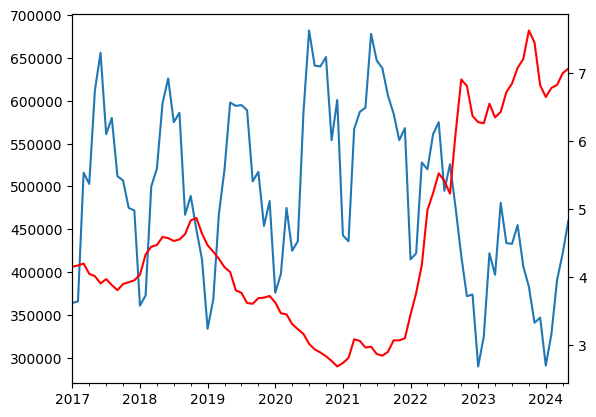

In [10]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['Rates'].plot(c='red')

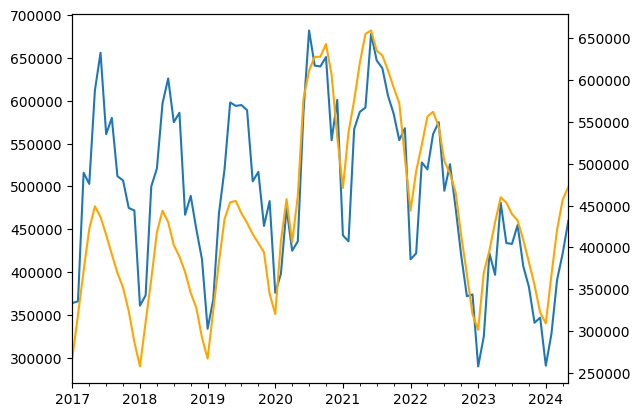

In [11]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['PendingLists'].plot(c='orange')

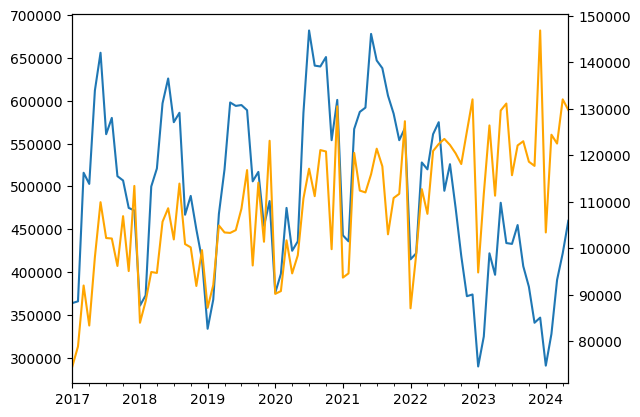

In [12]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['NewComps'].plot(c='orange')

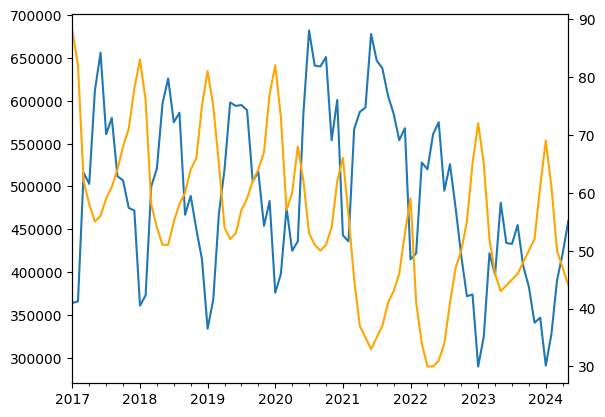

In [13]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['MedDayOnMar'].plot(c='orange')

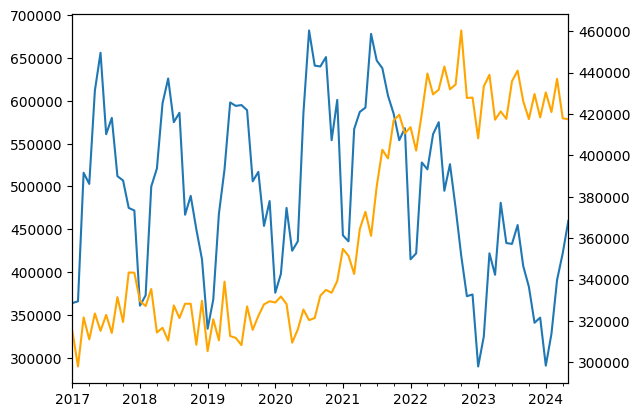

In [14]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['MedHomeSalePrice'].plot(c='orange')

In [ ]:
ax = final['HomeSales'].plot()
ax2 = ax.twinx()
ax2 = final['RealPCE'].plot(c='orange')

## There are a high number of features but we don't want to overfit the model so we will want to identify the most important features. We can do this by using a simple RandomForestRegression to find the 3 best features.


In [40]:
X = final_na[['Rates','PendingLists','ActiveLists','NewComps','NewPerms','NewStarts','UnEm25_BD','MedDayOnMar','MedHomeSalePrice','RealPCE']]
y = final_na['HomeSales']
estimator = RandomForestRegressor(n_estimators=5000, random_state=1)
#estimator = GradientBoostingRegressor(n_estimators=5000, random_state=1)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X, y)

In [41]:
# Below identifies the 3 best feature

filter = selector.support_
ranking = selector.ranking_

print("Mask data: ", filter)
print("Ranking: ", ranking) 
print(selector.feature_names_in_)
print("Selected features:")
print("Score:", selector.score(X,y))

Mask data:  [ True  True  True False False False False False False False]
Ranking:  [1 1 1 2 5 6 7 4 8 3]
['Rates' 'PendingLists' 'ActiveLists' 'NewComps' 'NewPerms' 'NewStarts'
 'UnEm25_BD' 'MedDayOnMar' 'MedHomeSalePrice' 'RealPCE']
Selected features:
Score: 0.9717085827254464


In [44]:
# Create a DataFrame where rows that that have null values are dropped and then split the Dataframe
tss = TimeSeriesSplit(n_splits=3)
final_na = final.dropna()
X = final_na[['Rates','PendingLists','ActiveLists']]
y = final_na[['HomeSales']]

for train_index, test_index in tss.split(final_na):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## Going to check for stationarity in the data

{'acf': -1.0738830282960234, 'p-value': 0.725373902517798, 'lag used': 12, '# of obs': 76, 'crit val': {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}}
{'acf': -2.431034140082296, 'p-value': 0.13316811885085988, 'lag used': 11, '# of obs': 76, 'crit val': {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}}
{'acf': -6.622802802438033, 'p-value': 5.978189805799107e-09, 'lag used': 12, '# of obs': 74, 'crit val': {'1%': -3.5219803175527606, '5%': -2.9014701097664504, '10%': -2.58807215485756}}


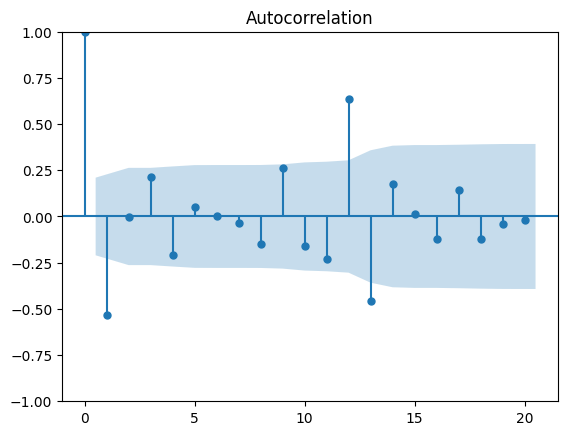

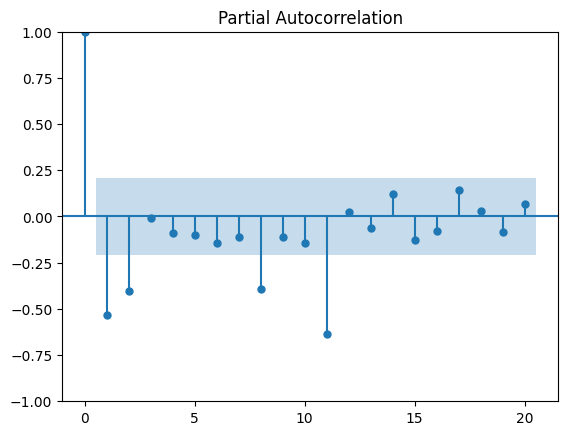

In [20]:
result = adfuller(final_na['HomeSales'])
print({'acf':result[0],'p-value':result[1],'lag used':result[2],'# of obs':result[3],'crit val':result[4]})

final['HS_1Diff'] = final['HomeSales'] - final['HomeSales'].shift(1)
result1 = adfuller(final.HS_1Diff.dropna())
print({'acf':result1[0],'p-value':result1[1],'lag used':result1[2],'# of obs':result1[3],'crit val':result1[4]})

final['HS_2Diff'] = final['HS_1Diff'] - final['HS_1Diff'].shift(1)
result2 = adfuller(final.HS_2Diff.dropna())
print({'acf':result2[0],'p-value':result2[1],'lag used':result2[2],'# of obs':result2[3],'crit val':result2[4]})
fig1=plot_acf(final['HS_2Diff'].dropna()) 
fig2=plot_pacf(final['HS_2Diff'].dropna())

{'acf': -0.8425861840034561, 'p-value': 0.8062916296622515, 'lag used': 5, '# of obs': 83, 'crit val': {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}}
{'acf': -6.2619734165311085, 'p-value': 4.2018244288646075e-08, 'lag used': 1, '# of obs': 86, 'crit val': {'1%': -3.5087828609430614, '5%': -2.895783561573195, '10%': -2.5850381719848565}}


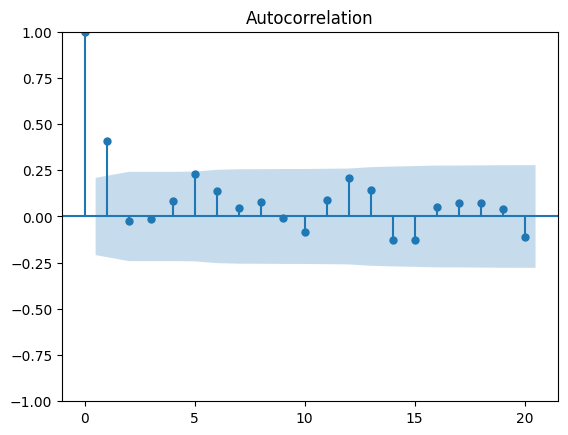

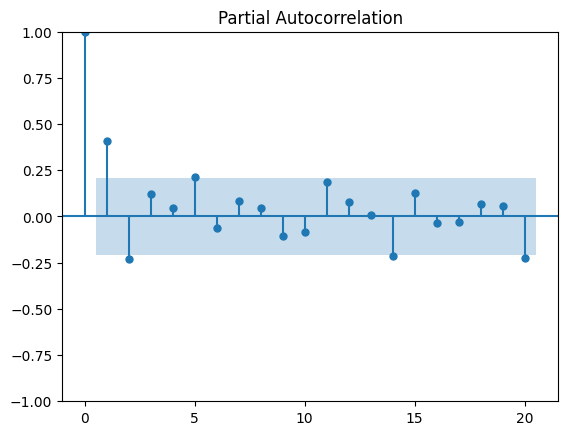

In [21]:
result = adfuller(final['Rates'].dropna())
print({'acf':result[0],'p-value':result[1],'lag used':result[2],'# of obs':result[3],'crit val':result[4]})

final['Rates_1D'] = final['Rates'] - final['Rates'].shift(1) 
result1 = adfuller(final['Rates_1D'].dropna())
print({'acf':result1[0],'p-value':result1[1],'lag used':result1[2],'# of obs':result1[3],'crit val':result1[4]})

fig1=plot_acf(final['Rates_1D'].dropna()) 
fig2=plot_pacf(final['Rates_1D'].dropna())


{'acf': -2.466842453538315, 'p-value': 0.12375172796674039, 'lag used': 12, '# of obs': 76, 'crit val': {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}}
{'acf': -1.5312589710722158, 'p-value': 0.5179952241500907, 'lag used': 11, '# of obs': 76, 'crit val': {'1%': -3.5194805351545413, '5%': -2.9003945086747343, '10%': -2.5874984279778395}}
{'acf': -5.61096146483022, 'p-value': 1.203820160494463e-06, 'lag used': 12, '# of obs': 74, 'crit val': {'1%': -3.5219803175527606, '5%': -2.9014701097664504, '10%': -2.58807215485756}}


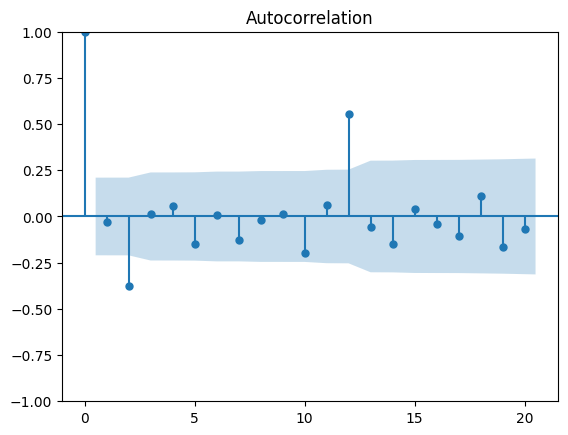

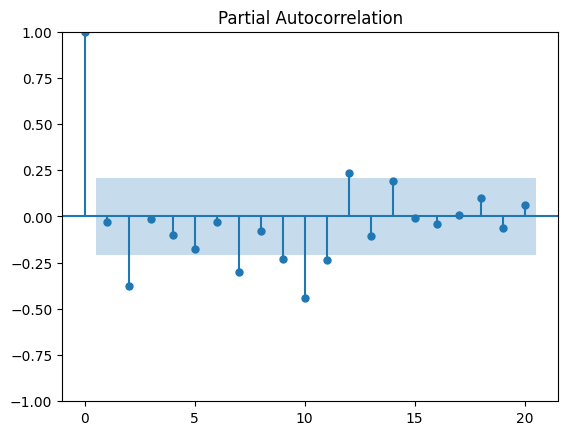

In [22]:

result = adfuller(final['PendingLists'].dropna())
print({'acf':result[0],'p-value':result[1],'lag used':result[2],'# of obs':result[3],'crit val':result[4]})

final['PL_1Diff'] = final['PendingLists'] - final['PendingLists'].shift(1) 
result1 = adfuller(final['PL_1Diff'].dropna())
print({'acf':result1[0],'p-value':result1[1],'lag used':result1[2],'# of obs':result1[3],'crit val':result1[4]})

final['PL_2Diff'] = final['PL_1Diff'] - final['PL_1Diff'].shift(1)
result2 = adfuller(final['PL_2Diff'].dropna())
print({'acf':result2[0],'p-value':result2[1],'lag used':result2[2],'# of obs':result2[3],'crit val':result2[4]})

fig1=plot_acf(final['PL_2Diff'].dropna()) 
fig2=plot_pacf(final['PL_2Diff'].dropna())


{'acf': -1.8495374283615533, 'p-value': 0.35615958049908325, 'lag used': 11, '# of obs': 77, 'crit val': {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}}
{'acf': -1.4324635045789467, 'p-value': 0.5666175965711584, 'lag used': 12, '# of obs': 75, 'crit val': {'1%': -3.520713130074074, '5%': -2.9009249540740742, '10%': -2.5877813777777776}}
{'acf': -3.2399600292327175, 'p-value': 0.01778506429827495, 'lag used': 11, '# of obs': 75, 'crit val': {'1%': -3.520713130074074, '5%': -2.9009249540740742, '10%': -2.5877813777777776}}


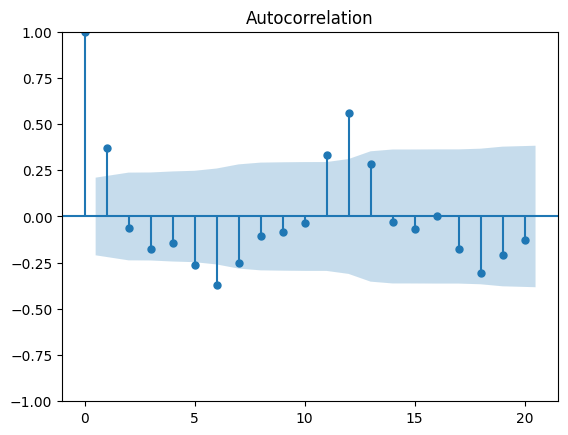

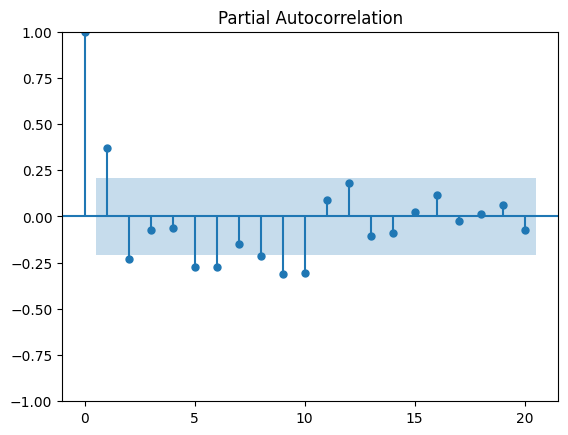

In [23]:
result = adfuller(final['ActiveLists'].dropna())
print({'acf':result[0],'p-value':result[1],'lag used':result[2],'# of obs':result[3],'crit val':result[4]})

final['AL_1Diff'] = final['ActiveLists'] - final['ActiveLists'].shift(1) 
result1 = adfuller(final['AL_1Diff'].dropna())
print({'acf':result1[0],'p-value':result1[1],'lag used':result1[2],'# of obs':result1[3],'crit val':result1[4]})

final['AL_2Diff'] = final['AL_1Diff'] - final['AL_1Diff'].shift(1)
result2 = adfuller(final['AL_2Diff'].dropna())
print({'acf':result2[0],'p-value':result2[1],'lag used':result2[2],'# of obs':result2[3],'crit val':result2[4]})

fig1=plot_acf(final['AL_2Diff'].dropna()) 
fig2=plot_pacf(final['AL_2Diff'].dropna())

## Using a default auto-arima to get an idea of where to start with the parameters

In [47]:

arr1 = np.array(X_train).reshape(-1,3)
arr2 = np.array(y_train).reshape(-1,1)
stepwise_fit = auto_arima(arr2,arr1, start_p = 0, start_q = 0,
                          max_p = 3, max_q = 3, m = 3,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[3] intercept   : AIC=1528.715, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=1543.547, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=1533.421, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=1528.481, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=1740.570, Time=0.00 sec
 ARIMA(0,0,1)(0,1,0)[3] intercept   : AIC=1544.770, Time=0.02 sec
 ARIMA(0,0,1)(1,1,1)[3] intercept   : AIC=1530.470, Time=0.07 sec
 ARIMA(0,0,1)(0,1,2)[3] intercept   : AIC=1530.460, Time=0.09 sec
 ARIMA(0,0,1)(1,1,0)[3] intercept   : AIC=1533.469, Time=0.05 sec
 ARIMA(0,0,1)(1,1,2)[3] intercept   : AIC=1528.400, Time=0.21 sec
 ARIMA(0,0,1)(2,1,2)[3] intercept   : AIC=1529.126, Time=0.31 sec
 ARIMA(0,0,1)(2,1,1)[3] intercept   : AIC=1531.399, Time=0.16 sec
 ARIMA(0,0,0)(1,1,2)[3] intercept   : AIC=1527.248, Time=0.19 sec
 ARIMA(0,0,0)(0,1,2)[3] intercept   : AIC=1530.575, Time=0.04 sec
 ARIMA(0,0,0)(1,1,1)[3] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   66
Model:             SARIMAX(2, 0, 1)x(1, 1, [1, 2], 3)   Log Likelihood                -750.881
Date:                                Mon, 15 Jul 2024   AIC                           1521.762
Time:                                        23:23:59   BIC                           1543.194
Sample:                                             0   HQIC                          1530.191
                                                 - 66                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -9811.0996   1.89e+04     -0.518      0.605   -4.69e+04    2.73e+04
x2             1.1097      0.105     10.532      0.000       0.903       1.316
x3             0.2009      0.065      3.084      0.002       0.073       0.329
ar.L1          0.7883      0.409      1.929      0.054      -0.013       1.589
ar.L2          0.1329      0.339      0.392      0.695      -0.532       0.798
ma.L1         -0.6774      0.299     -2.263      0.024      -1.264      -0.091
ar.S.L3       -0.9917      0.104     -9.513      0.000      -1.196      -0.787
ma.S.L3        0.2168      0.335      0.647      0.518      -0.440       0.873
ma.S.L6       -0.7062      0.338     -2.089      0.037      -1.369      -0.044
sigma2       1.72e+09      0.006   2.74e+11      0.000    1.72e+09    1.72e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.99   Prob(JB):                         0.49
Heteroskedasticity (H):               0.88   Skew:                            -0.32
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.2e+28. Standard errors may be unstable.
"""

In [74]:
model=sm.tsa.SARIMAX(y_train,X_train,order=(2,0,1),seasonal_order=(1, 1, 2, 3))
sm_result=model.fit()
sm_summ = sm_result.summary()
sm_summ

C:\Users\Matt\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Matt\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Matt\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Matt\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              HomeSales   No. Observations:                   66
Model:             SARIMAX(2, 0, 1)x(1, 1, [1, 2], 3)   Log Likelihood                -750.881
Date:                                Tue, 16 Jul 2024   AIC                           1521.762
Time:                                        11:10:14   BIC                           1543.194
Sample:                                    03-01-2017   HQIC                          1530.191
                                         - 08-01-2022                                         
Covariance Type:                                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Rates        -9811.0996   1.89e+04     -0.518      0.605   -4.69e+04    2.73e+04
PendingLists     1.1097      0.105     10.532      0.000       0.903       1.316
ActiveLists      0.2009      0.065      3.084      0.002       0.073       0.329
ar.L1            0.7883      0.409      1.929      0.054      -0.013       1.589
ar.L2            0.1329      0.339      0.392      0.695      -0.532       0.798
ma.L1           -0.6774      0.299     -2.263      0.024      -1.264      -0.091
ar.S.L3         -0.9917      0.104     -9.513      0.000      -1.196      -0.787
ma.S.L3          0.2168      0.335      0.647      0.518      -0.440       0.873
ma.S.L6         -0.7062      0.338     -2.089      0.037      -1.369      -0.044
sigma2         1.72e+09      0.006   2.74e+11      0.000    1.72e+09    1.72e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.99   Prob(JB):                         0.49
Heteroskedasticity (H):               0.88   Skew:                            -0.32
Prob(H) (two-sided):                  0.78   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.2e+28. Standard errors may be unstable.
"""

<Axes: ylabel='Density'>

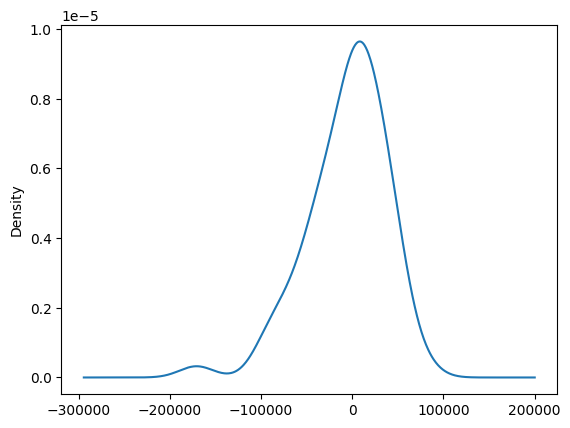

In [50]:
result.resid.plot(kind='kde')


C:\Users\Matt\AppData\Local\Temp\ipykernel_1684\2072699375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['prediction_1']=pd.DataFrame(result.predict(start=0, end=len(final_na[:-1]),exog=excog_fore))


'                                 SARIMAX Results                                  \nDep. Variable:  ,HomeSales                         ,  No. Observations:  ,66      \nModel:          ,SARIMAX(2, 0, 1)x(1, 1, [1, 2], 3),  Log Likelihood     ,-750.881\nDate:           ,Tue, 16 Jul 2024                  ,  AIC                ,1521.762\nTime:           ,11:10:14                          ,  BIC                ,1543.194\nSample:         ,03-01-2017                        ,  HQIC               ,1530.191\n                ,- 08-01-2022                      ,                     ,        \nCovariance Type:,opg                               ,                     ,        \n            ,   coef   , std err ,    z    ,P>|z| ,  [0.025 ,  0.975] \nRates       ,-9811.0996, 1.89e+04,   -0.518, 0.605,-4.69e+04, 2.73e+04\nPendingLists,    1.1097,    0.105,   10.532, 0.000,    0.903,    1.316\nActiveLists ,    0.2009,    0.065,    3.084, 0.002,    0.073,    0.329\nar.L1       ,    0.7883,    0.409,    1

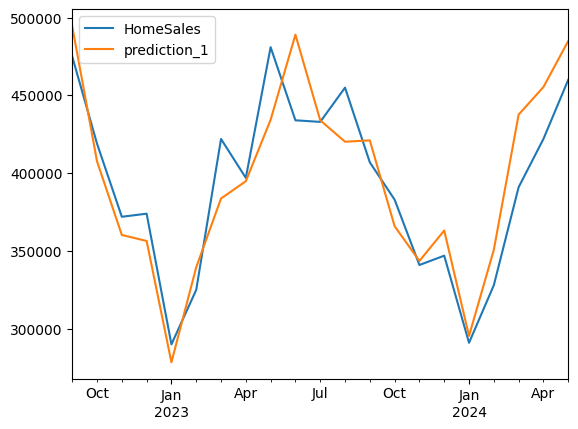

In [77]:

excog_fore = X_test
y_test['prediction_1']=pd.DataFrame(result.predict(start=0, end=len(final_na[:-1]),exog=excog_fore))
result.summary()
y_test[['HomeSales','prediction_1']].plot()

tableau = final_na.join(y_test[['prediction_1']], how='left')
tableau.to_excel('HomeSalesPredictionData.xlsx',sheet_name='Data')
sm_summ.as_csv()

